In [1]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce
import datetime as dt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [233]:
WINDOW_SIZE = 10
day = 35
game_base = dt.timedelta(day)
game_base_int = day
y='on_base'
t = 9
dpath = '../dataset'
load_data =False

In [230]:
def make_time_series(df,window_size):
    
    barell = ['2타','3타','홈런']
    
    on_base = ['안타','2타','3타','홈런','사구','볼넷','고4']
    out = ['병살','삼진','희타']
    etc = ['타수','도루','투구']
    
    is_bin = ['선발']


    # for calcaul
    total_base =['타수','볼넷','고4','사구','희타']
    hit = ['안타','2타','3타','홈런']
    
    sample_list = []
    
    for i in range(1,len(df),window_size):
        
        single = df[-i:-(i+window_size):-1].groupby(['이름','year'])[on_base+out+etc].sum()
        single['gap'] = df[-i:-(i+window_size):-1].iloc[0,3] - df[-i:-(i+window_size):-1].iloc[-1,3]
        
        single['num_game'] = df[-i:-(i+window_size):-1].shape[0]
        single['on_base']= single[on_base].sum(axis=1)/single[total_base].sum(axis=1)
        single['slg'] = (single[hit] * [1,2,3,4]).sum(axis=1)/single['타수']
        sample_list.append(single)
        
        
    result = pd.concat(sample_list).reset_index()
    result.index = ['t'+str(i) for i in range(1,len(result)+1)]
    
   
    
    return result
    

In [231]:
dataset = pd.read_csv(os.path.join(dpath, 'feature_baseball.csv'))
dataset.date=pd.to_datetime(dataset.date)

In [232]:
tot_base = []
for y in [2018,2019,2020,2021]:    
    base_year = dataset[(dataset['year']==y)]
    total_time_seires = []
    players= base_year['이름'].value_counts().keys().to_list()
    for player in players:
        sample_df = base_year[(base_year['이름']==player)]
        total_time_seires.append(make_time_series(sample_df, WINDOW_SIZE))
    base_datas = pd.concat(total_time_seires)
    tot_base.append(base_datas)

base_per_game = pd.concat(tot_base)
dataset_game = base_per_game[(base_per_game.gap <= game_base)&(base_per_game.num_game==WINDOW_SIZE)]
dataset_game.gap = dataset_game.gap.astype(str).str[:-4].astype(int)

KeyboardInterrupt: 

In [204]:
if load_data:
    dataset_game = pd.read_csv('../dataset/base_per_game_tot.csv')
    dataset_game.rename(columns={'Unnamed: 0':'series_index'},inplace=True)

In [205]:
dataset_game=dataset_game.dropna()


In [206]:
dataset_game

,이름,year,안타,2타,3타,홈런,사구,볼넷,고4,병살,삼진,희타,타수,도루,투구,gap,num_game,on_base,slg
t1,로맥,2018,6,0,0,4,1,3,0,1,11,0,36,0,150,13,9,0.350000,0.611111
t2,로맥,2018,10,1,0,3,0,7,0,0,5,0,34,1,178,24,9,0.512195,0.705882
t3,로맥,2018,10,0,0,0,2,6,0,0,5,0,30,0,158,10,9,0.473684,0.333333
t4,로맥,2018,10,2,0,3,1,3,0,1,6,0,37,0,149,9,9,0.463415,0.702703
t5,로맥,2018,8,1,0,0,2,2,0,0,8,0,36,1,158,27,9,0.325000,0.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t2,나주환,2021,3,0,0,0,0,0,0,1,6,0,17,0,60,12,9,0.176471,0.176471
t2,강민국,2021,9,2,0,0,0,2,0,0,4,2,26,0,118,11,9,0.433333,0.500000
t1,이해창,2021,8,3,0,0,0,1,0,0,9,1,29,0,126,26,9,0.387097,0.482759
t1,김수환,2021,6,2,0,1,0,2,0,1,11,0,27,0,115,11,9,0.379310,0.518519


In [207]:
def stack_ts(df, window_size, game_base, year, y, t_stamp):
    game=df[df.year==year]
    tot_players=game[(game.gap < game_base)].reset_index().groupby('이름')['index'].count().gt(t_stamp-1).items()
    players=[name for name, flag in tot_players if flag==True]
    
    sequence = []
    for name in players:
    
        sequence.append(game[(game.gap < game_base)&(game['이름']==name)][y].to_frame().T.iloc[:,:t_stamp])
        sequence[-1].columns= ['t'+str(i) for i in range(0,t_stamp)]
        
    tot_seq = reduce(lambda left, right: pd.concat([left,right]), sequence)
    tot_seq.index = players
    tot_seq=tot_seq.dropna()
    print(f'{year} year feature {y} ==={window_size} ws ')
    return tot_seq

In [208]:
def stack_ts_interpol(df, window_size, game_base, year, y, t_stamp):
    game=df[df.year==year]
    tot_players=game[(game.gap < game_base)].reset_index().groupby('이름')['index'].count().gt(t_stamp-4).items()
    players=[name for name, flag in tot_players if flag==True]
    
    sequence = []
    for name in players:
    
        sequence.append(game[(game.gap < game_base)&(game['이름']==name)][y].to_frame().T.iloc[:,:t_stamp])
        sequence[-1].columns= ['t'+str(i) for i in range(0,t_stamp)]
        
    tot_seq = reduce(lambda left, right: pd.concat([left,right]), sequence)
    tot_seq.index = players
#     tot_seq=tot_seq.dropna()
    print(f'{year} year feature {y} ==={window_size} ws ')
    return tot_seq

In [209]:
# test = make_time_series_interpol(dataset_game, WINDOW_SIZE, game_base, 2020, y, t)
# test

In [226]:
seq = []
for year in [2018,2019,2020,2021]:
    seq.append(stack_ts(dataset_game, WINDOW_SIZE, game_base_int, year, y, t))
seqs = reduce(lambda left, right: pd.concat([left,right]), seq)

2018 year feature on_base ===9 ws 
2019 year feature on_base ===9 ws 
2020 year feature on_base ===9 ws 
2021 year feature on_base ===9 ws 


In [227]:
seqs

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
WO김재현,0.173913,0.272727,0.181818,0.285714,0.500000,0.250000,0.333333,0.346154,0.357143,0.333333
강민호,0.333333,0.361111,0.411765,0.437500,0.416667,0.531250,0.312500,0.312500,0.500000,0.645161
강백호,0.636364,0.391304,0.425000,0.523810,0.351351,0.378378,0.454545,0.473684,0.555556,0.424242
구자욱,0.622222,0.400000,0.375000,0.536585,0.708333,0.589744,0.365854,0.538462,0.348837,0.500000
권희동,0.487805,0.439024,0.702703,0.448276,0.500000,0.225000,0.485714,0.225806,0.552632,0.181818
...,...,...,...,...,...,...,...,...,...,...
박해민,0.475000,0.384615,0.416667,0.475000,0.414634,0.540541,0.589744,0.343750,0.350000,0.421053
배정대,0.500000,0.307692,0.444444,0.266667,0.435897,0.384615,0.536585,0.525000,0.476190,0.459459
전준우,0.388889,0.264706,0.575000,0.500000,0.511628,0.513514,0.485714,0.317073,0.538462,0.565217
정은원,0.457143,0.282051,0.513514,0.540541,0.511628,0.536585,0.500000,0.465116,0.585366,0.351351


In [228]:
seqs.to_csv(f'../dataset/seq_ts{t}_ws{WINDOW_SIZE}.csv',index_label='NAME')

강백호


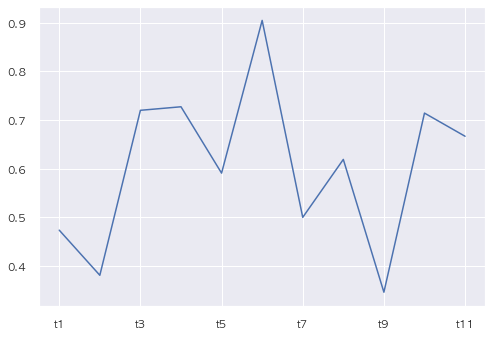

강승호


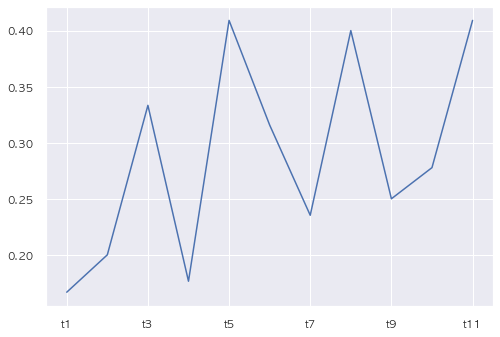

강진성


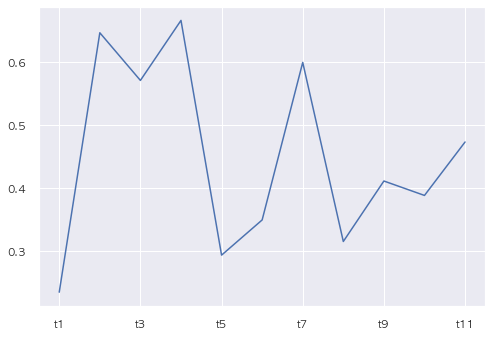

강한울


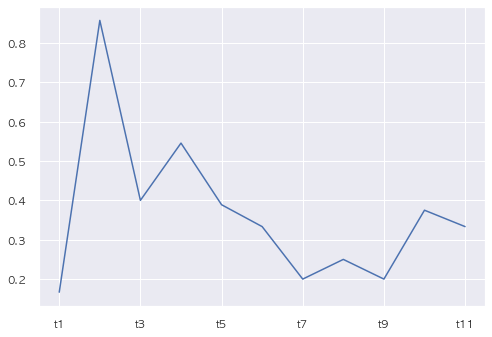

고종욱


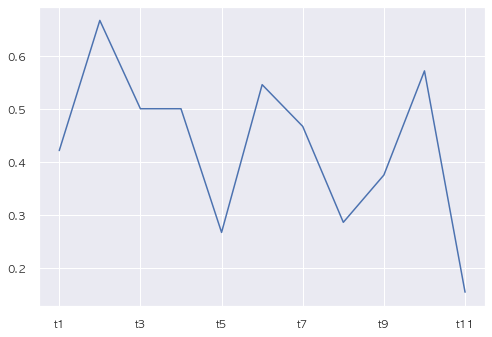

구자욱


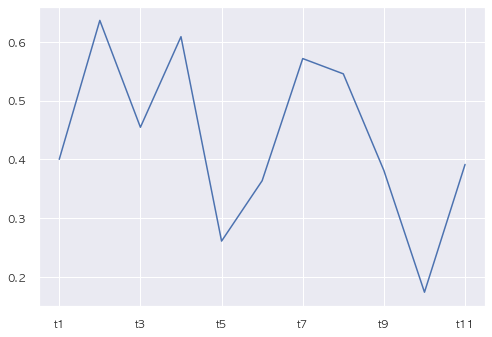

권동진


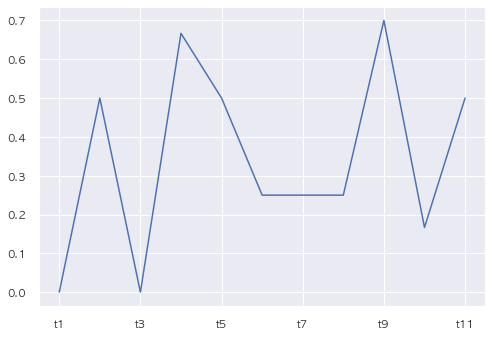

권희동


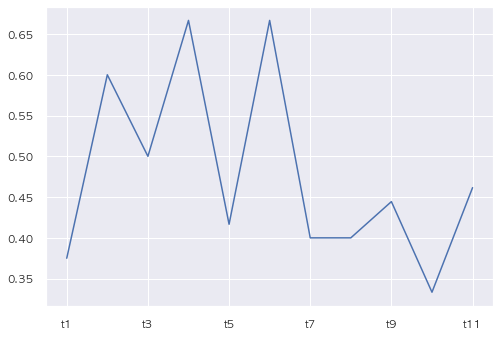

김강민


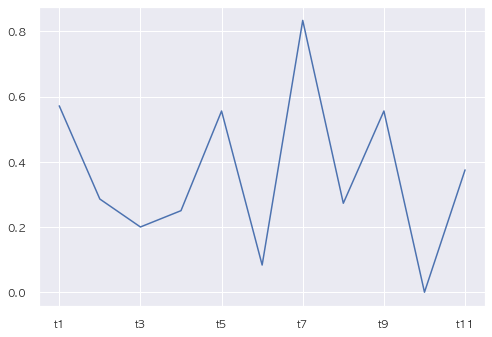

김민성


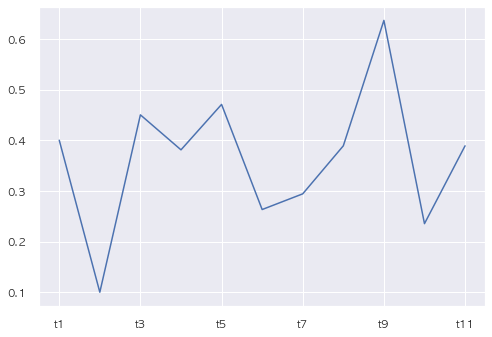

김민수


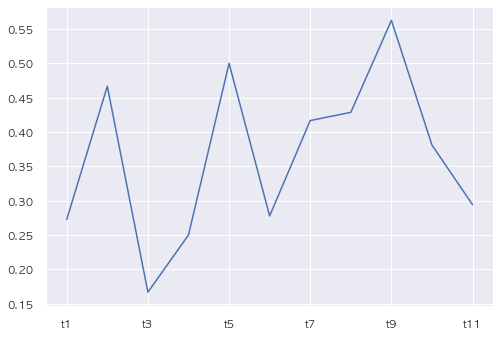

김민식


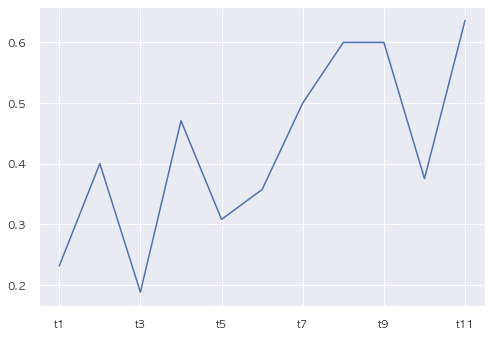

김상수


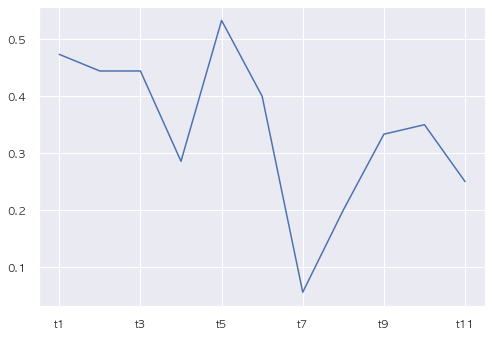

김선빈


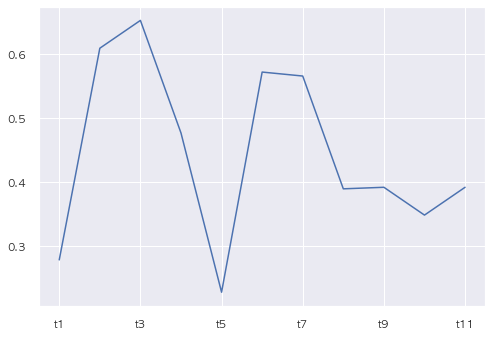

김성현


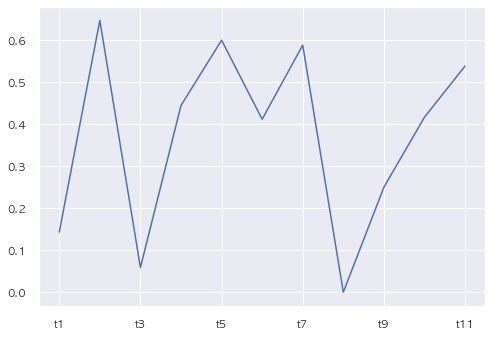

김용의


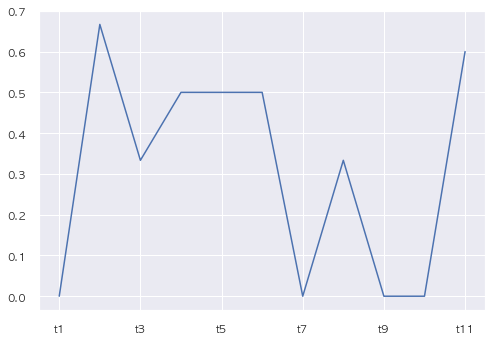

김웅빈


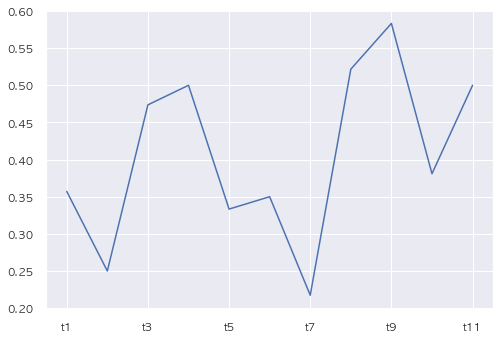

김인태


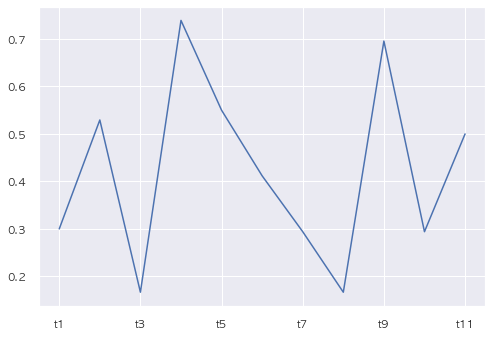

김재환


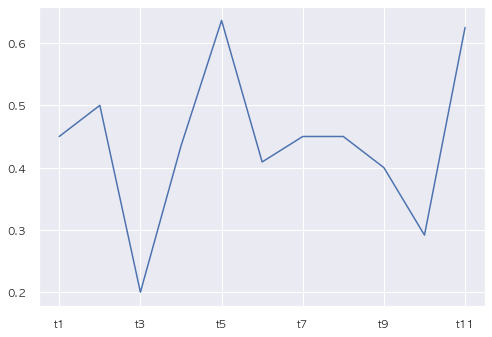

김지찬


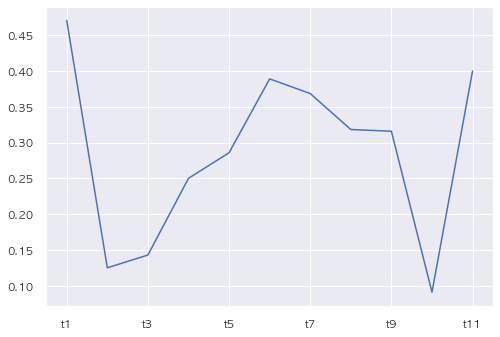

김찬형


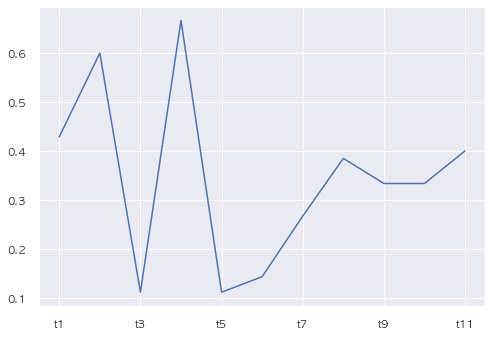

김태군


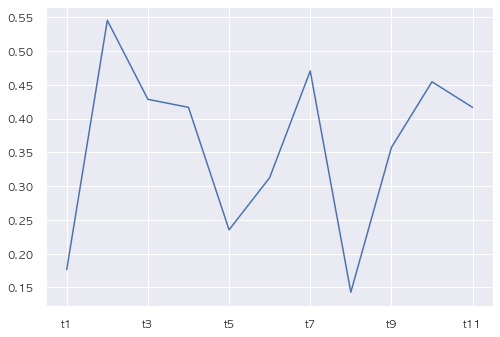

김태진


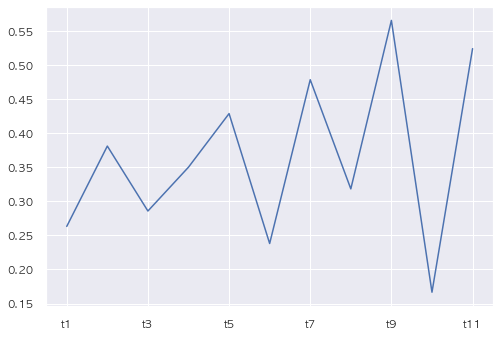

김헌곤


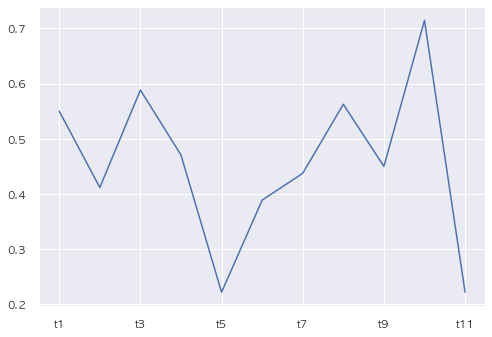

김현수


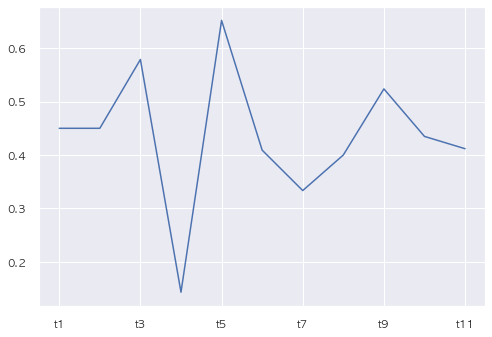

김혜성


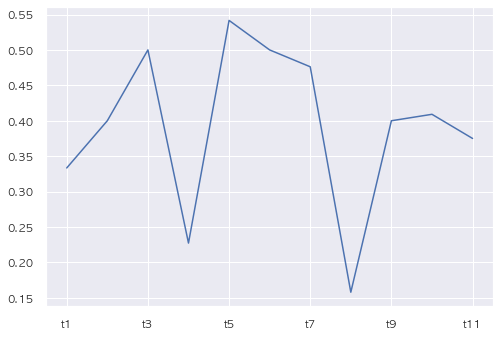

나성범


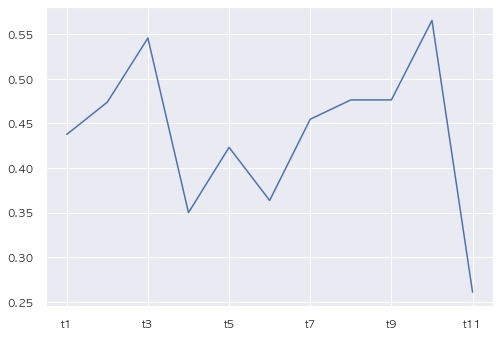

노시환


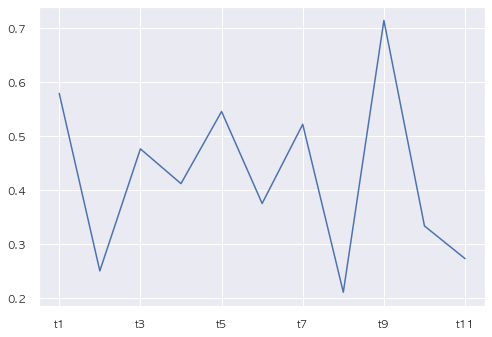

노진혁


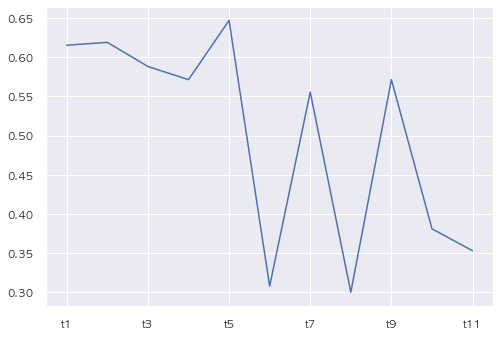

로맥


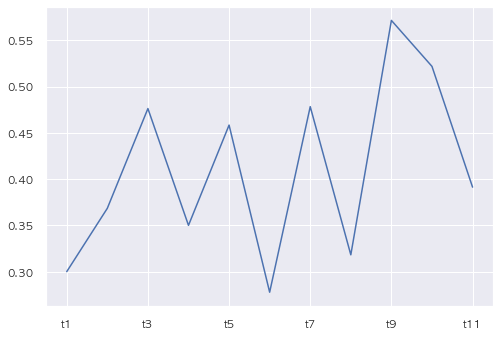

마차도


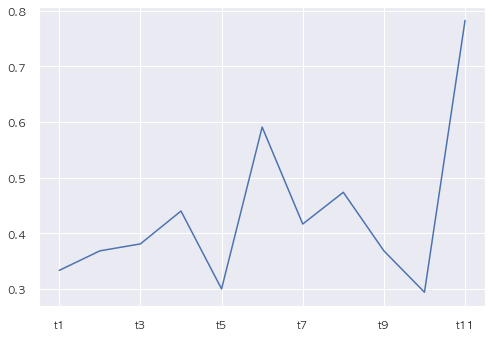

문보경


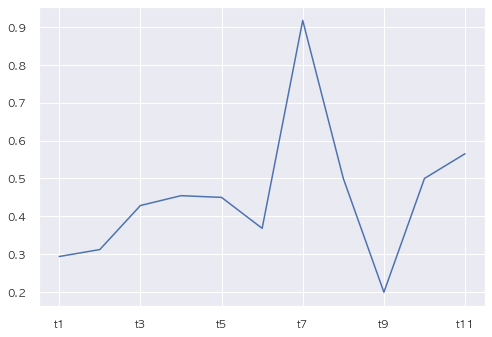

박건우


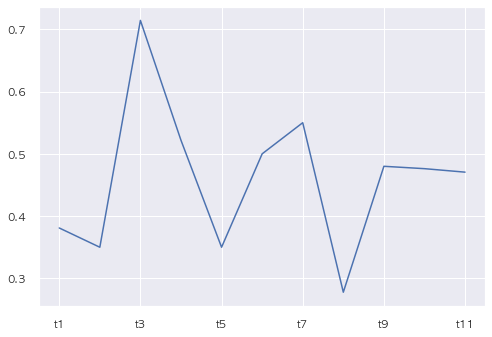

박경수


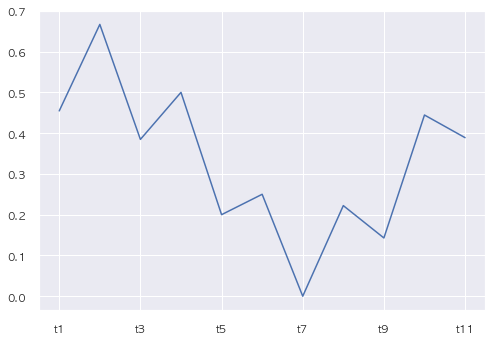

박계범


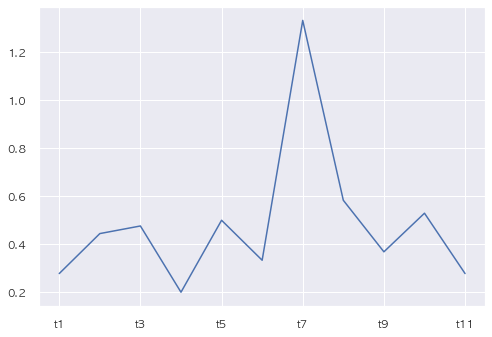

박동원


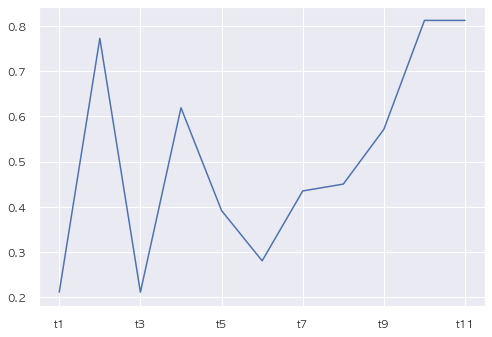

박병호


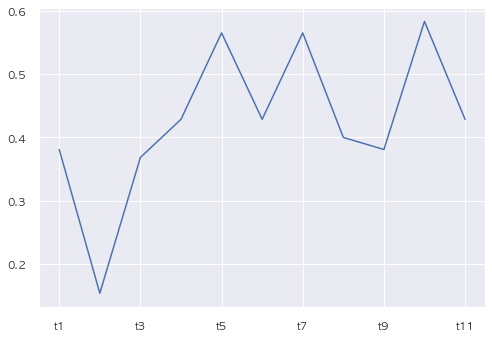

박석민


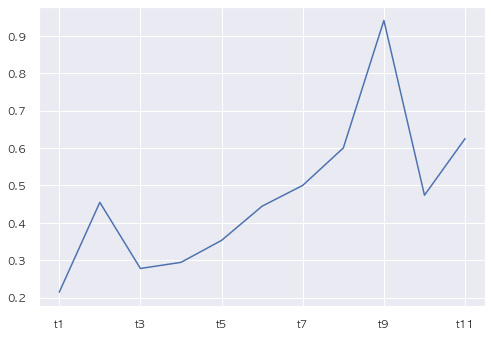

박성한


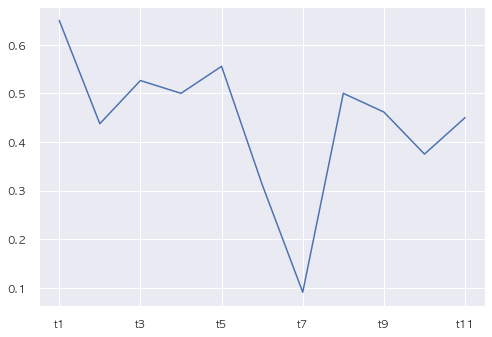

박준영


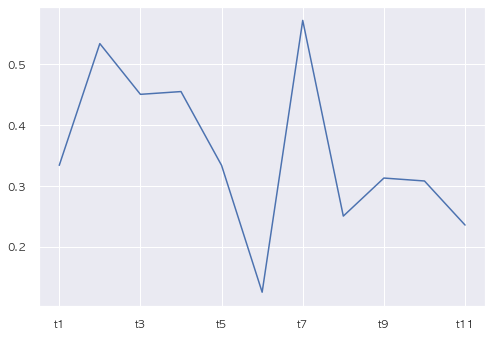

박찬호


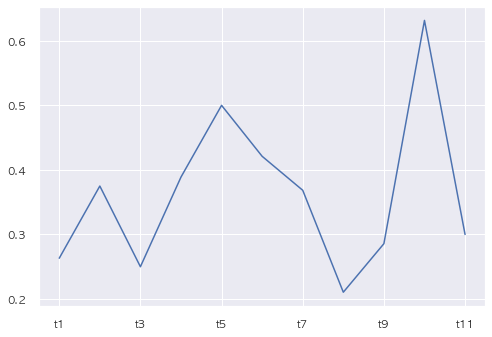

박해민


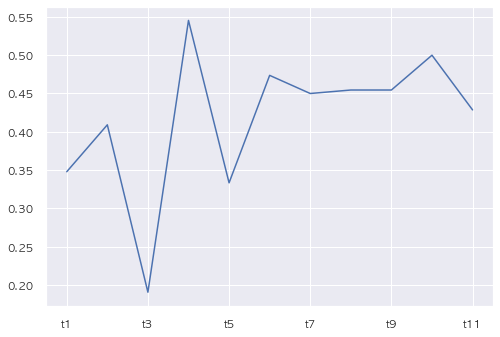

배정대


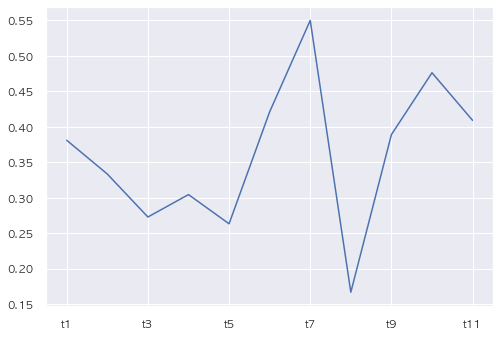

서건창


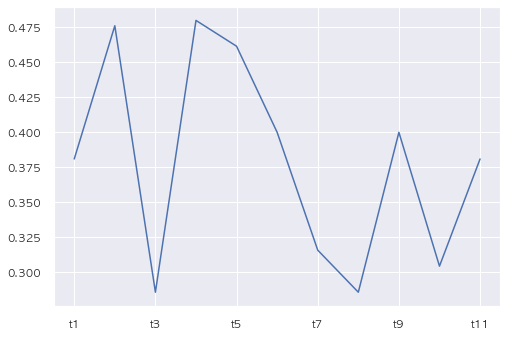

손아섭


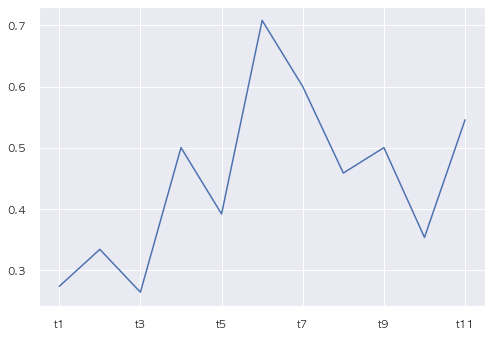

송민섭


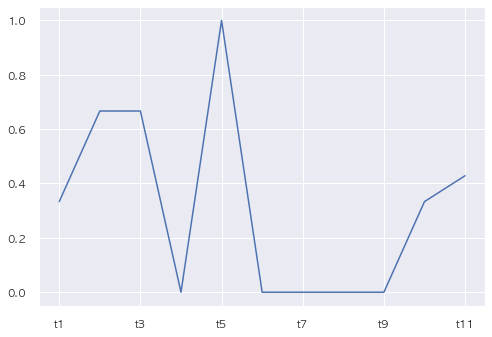

송우현


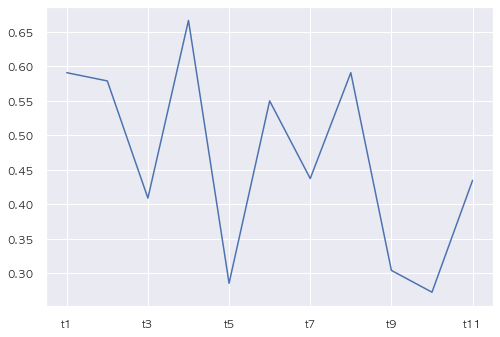

심우준


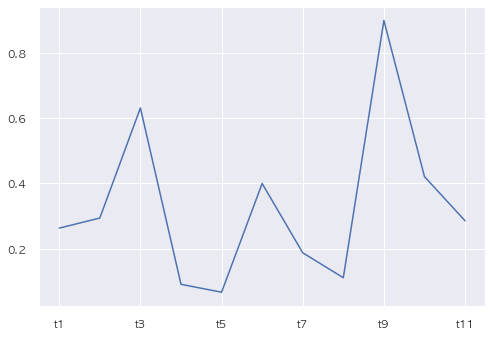

안재석


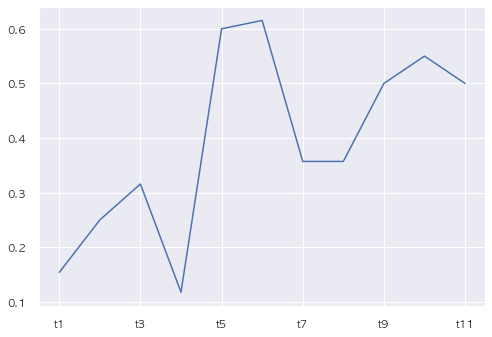

안치홍


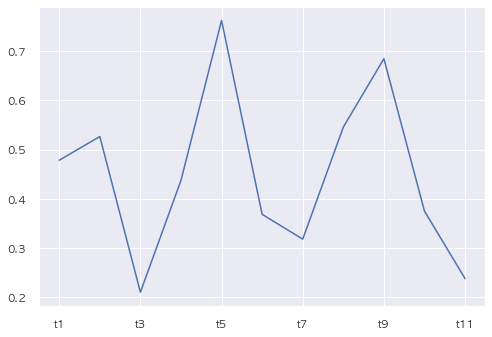

알몬테


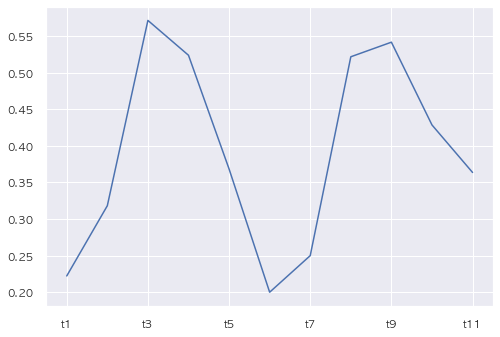

알테어


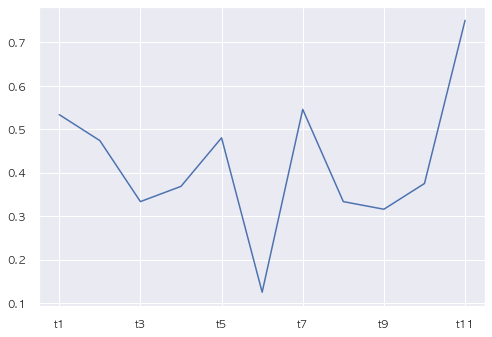

양석환


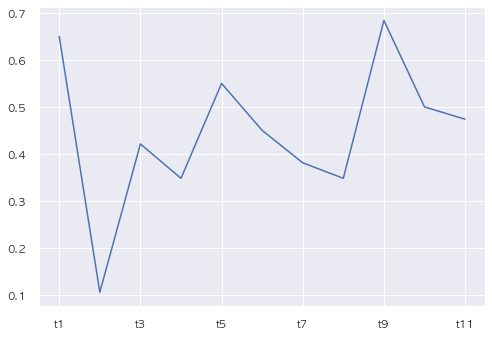

양의지


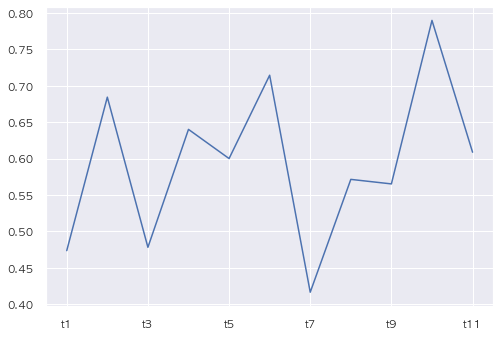

오재일


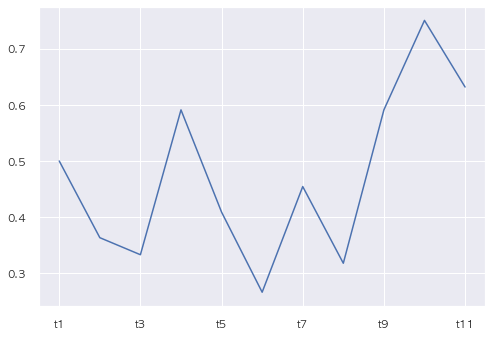

오지환


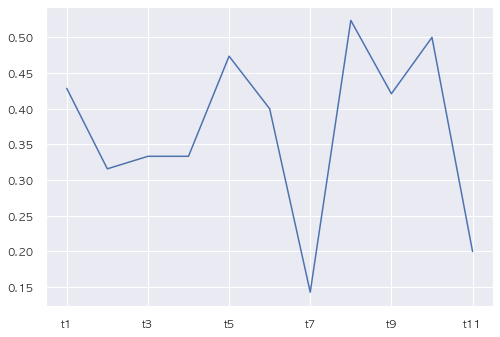

오태곤


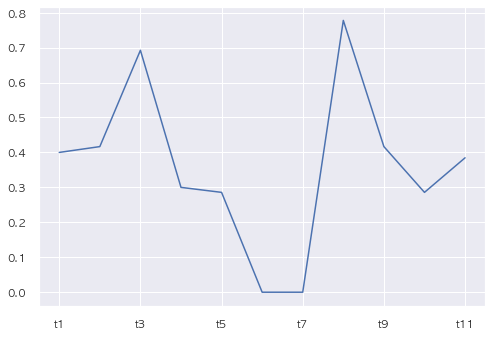

유강남


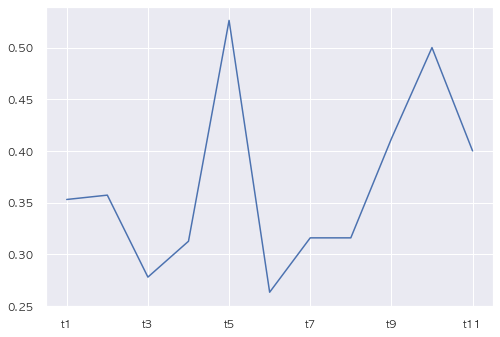

유한준


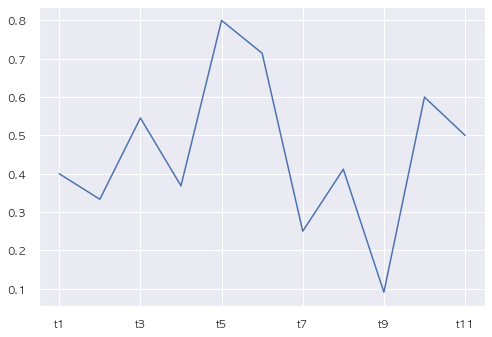

이대호


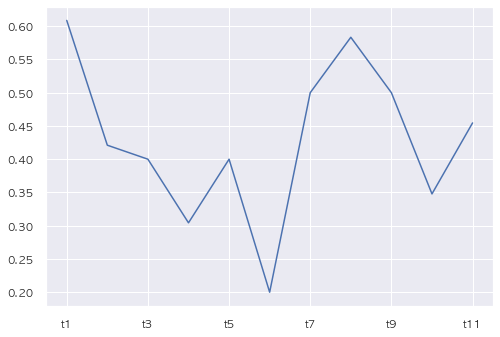

이명기


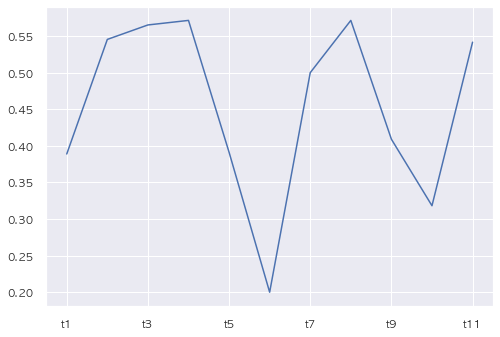

이용규


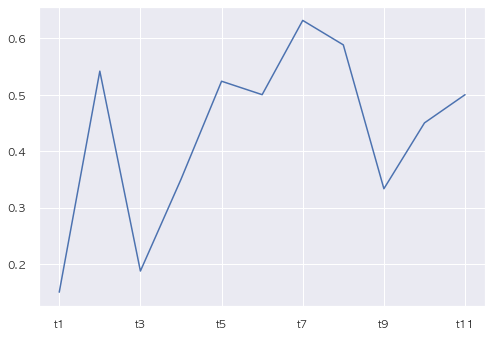

이원석


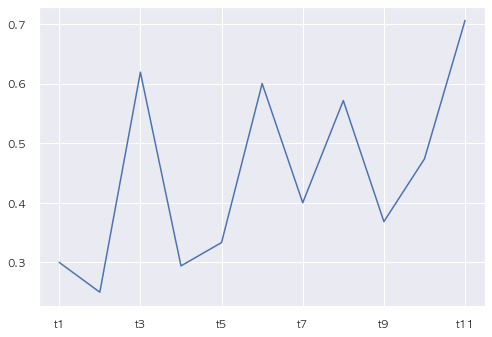

이재원


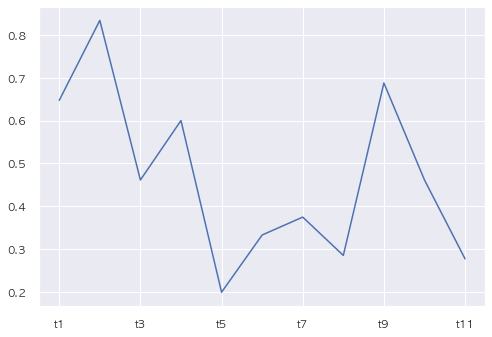

이정후


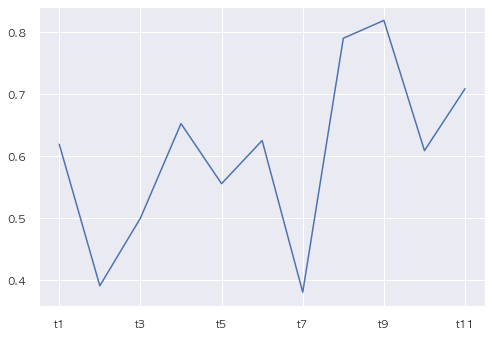

이지영


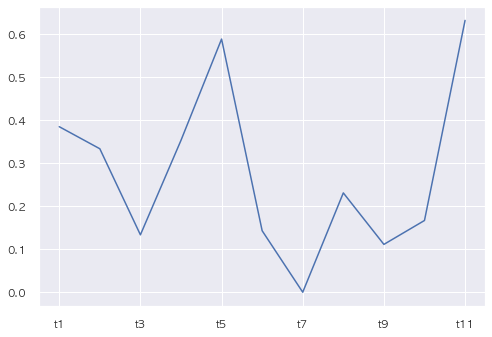

이창진


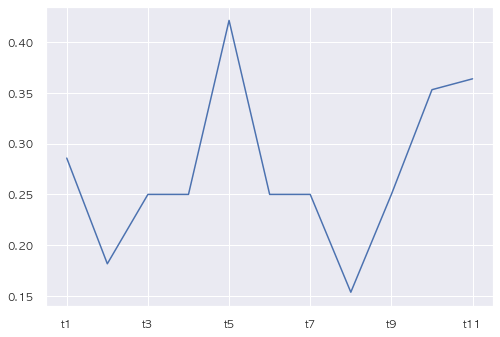

이천웅


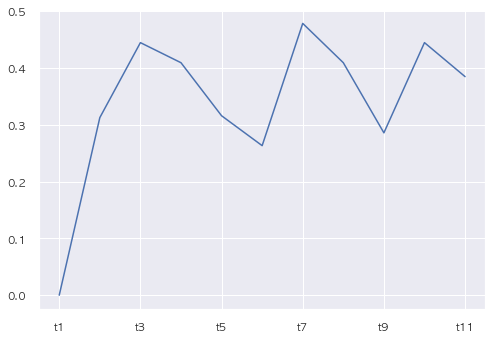

이형종


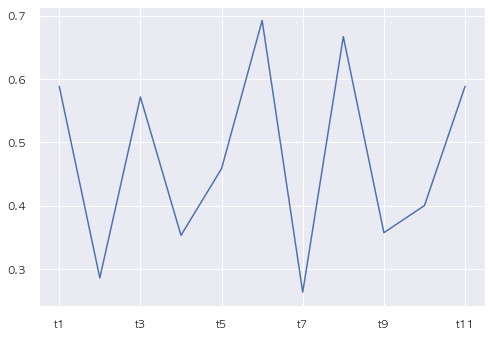

이흥련


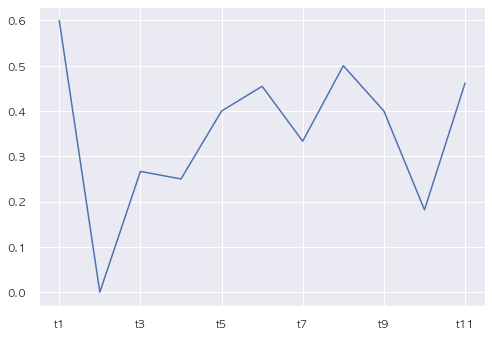

장성우


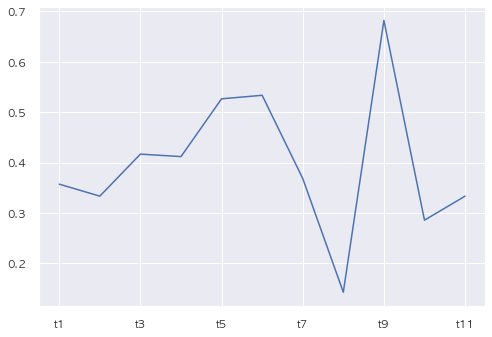

장승현


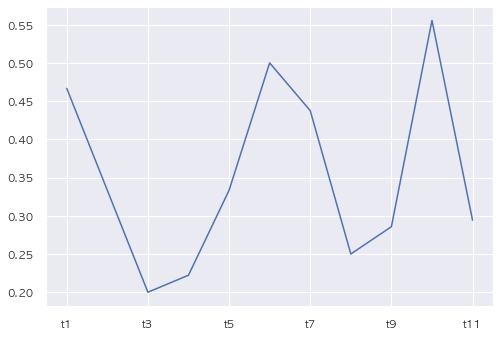

장운호


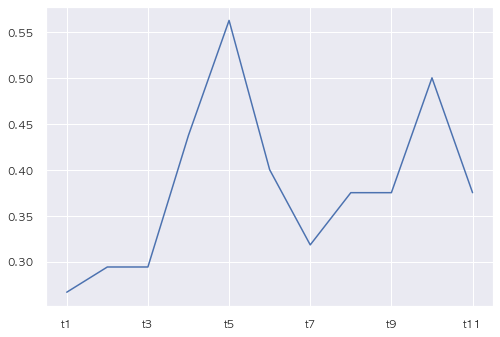

전병우


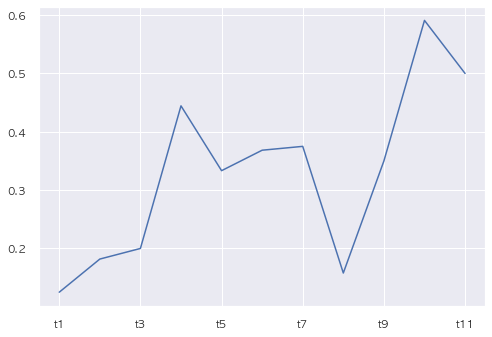

전준우


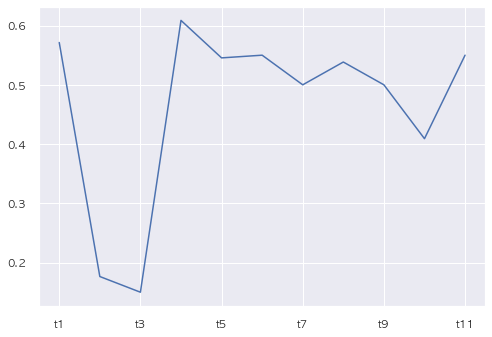

정은원


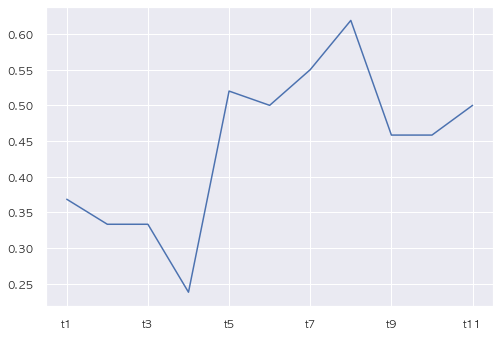

정의윤


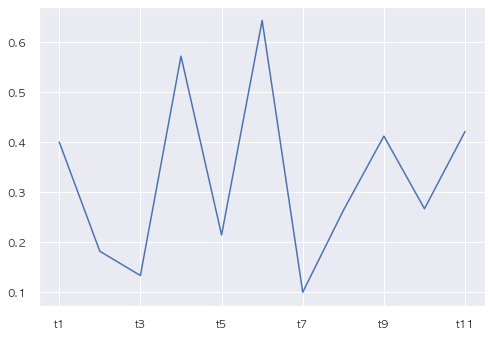

정주현


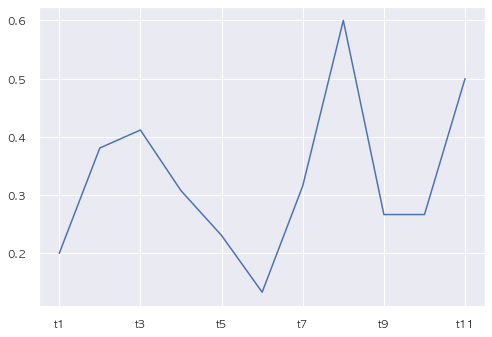

정훈


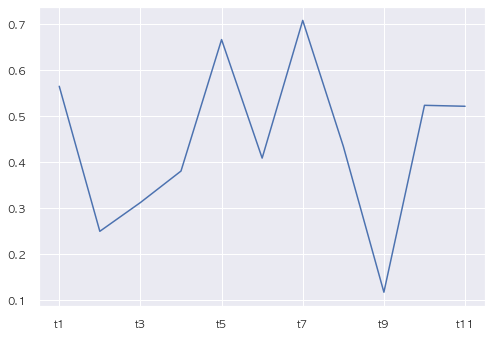

조수행


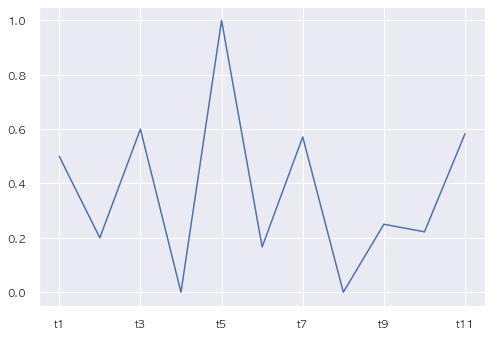

조용호


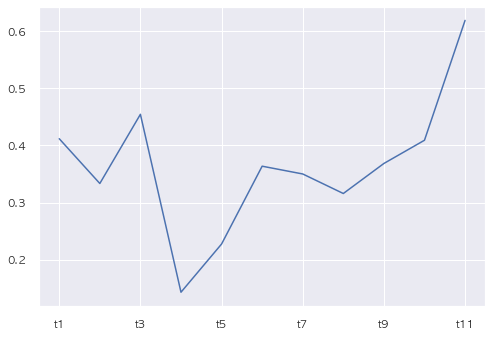

채은성


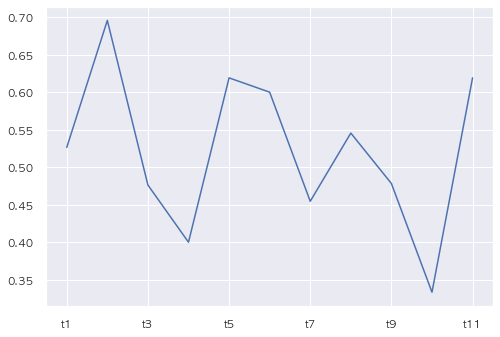

최원준


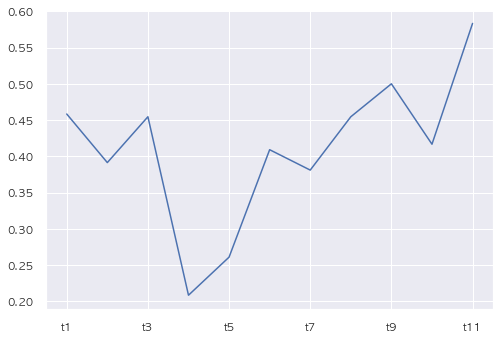

최재훈


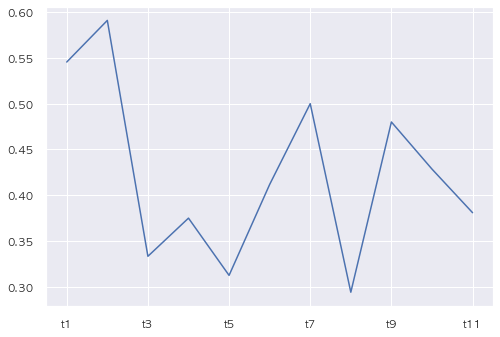

최정


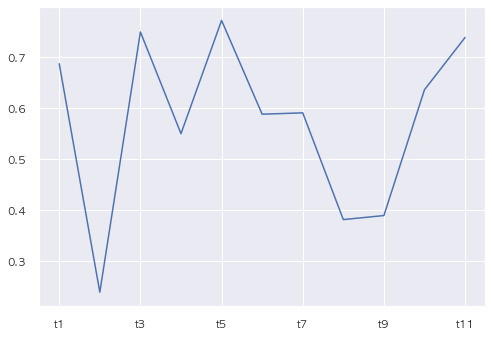

최주환


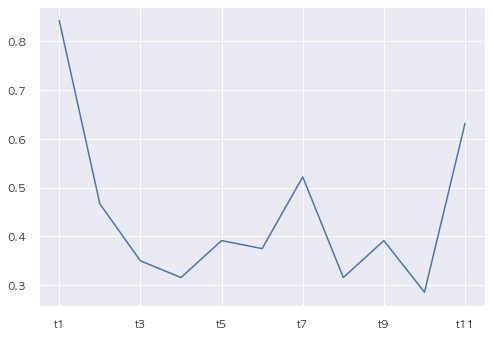

최지훈


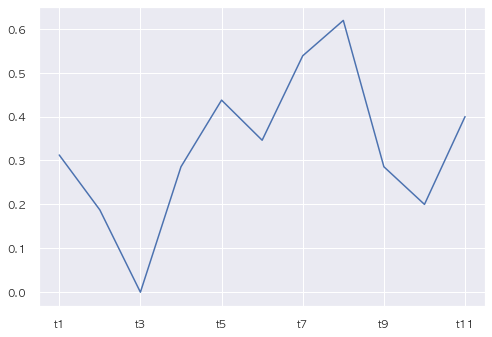

추신수


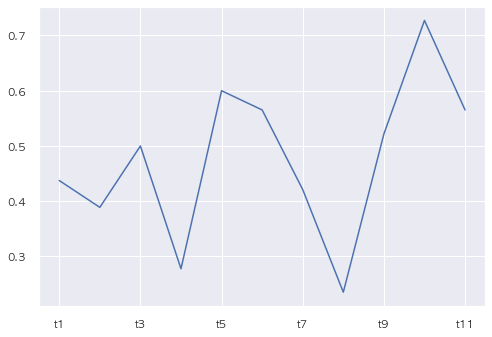

터커


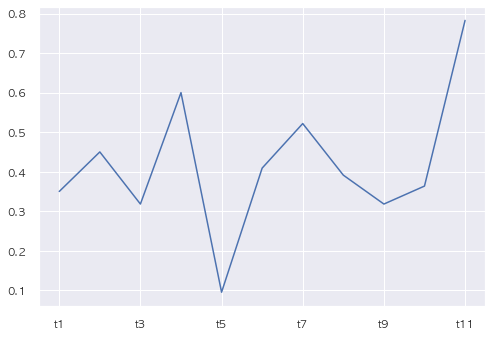

페르난데스


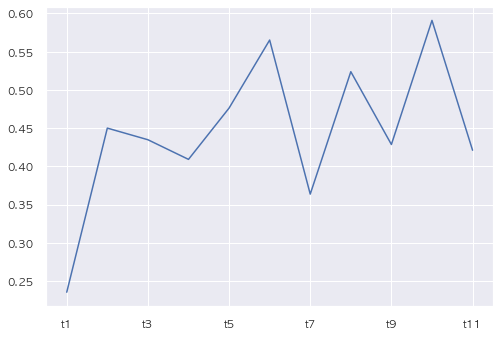

피렐라


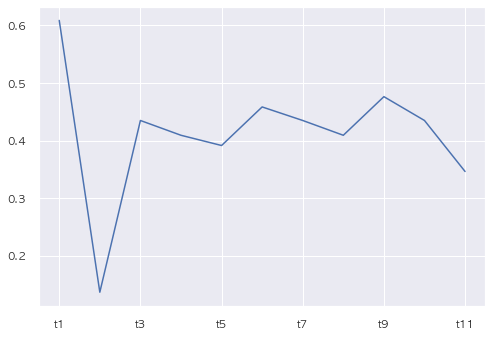

하주석


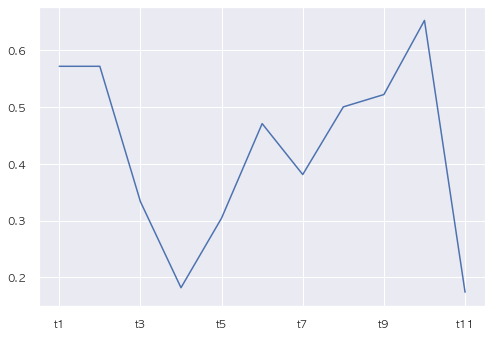

한동희


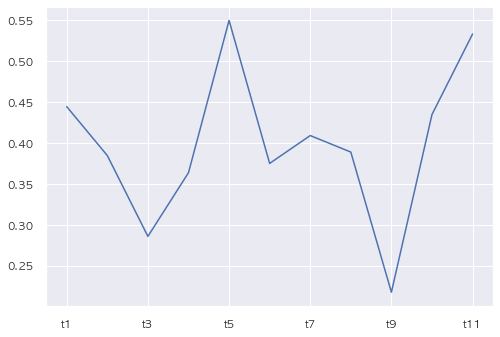

한승택


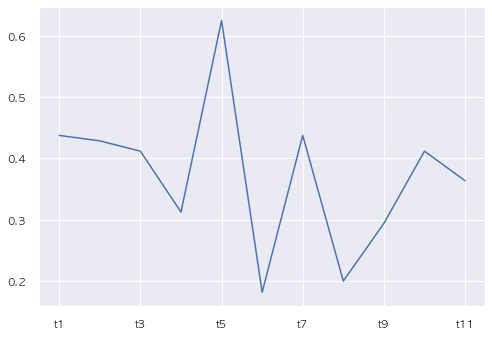

한유섬


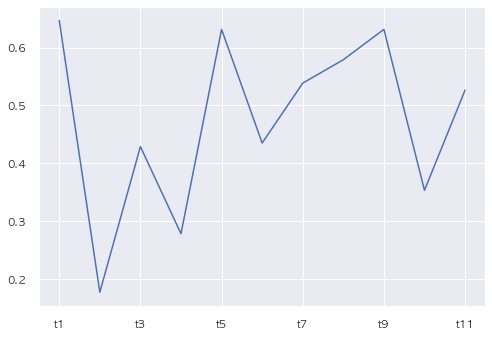

허경민


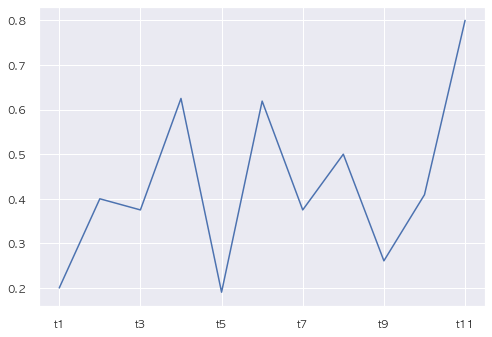

홍창기


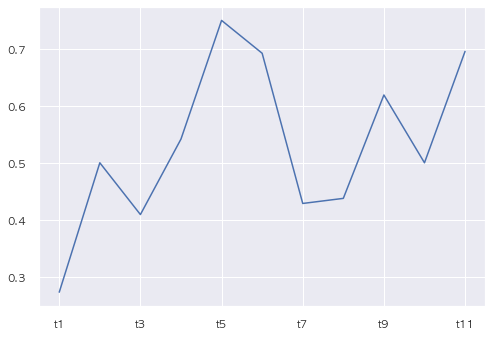

황재균


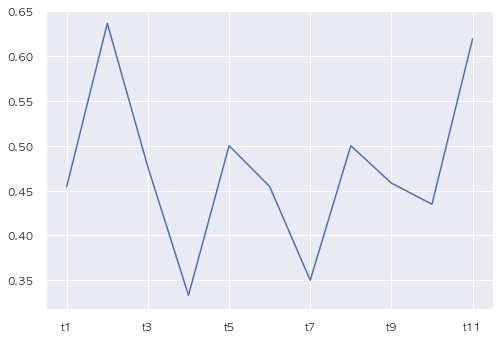

힐리


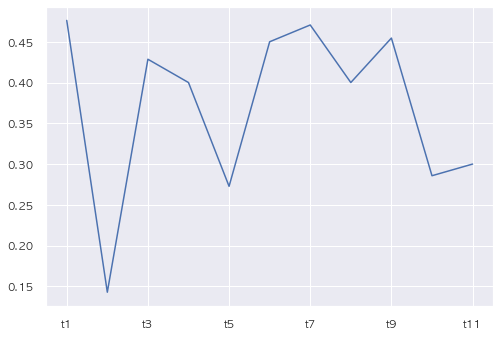

In [216]:
for i in  range(1,len(tot_seq)):
    print(tot_seq.index[i])
    tot_seq.iloc[i,:].plot()
    plt.show()

In [ ]:
박계범,안재석,알몬테,이창진,최주환

In [218]:
target = ['강백호', '김재환', '김현수', '로맥', '박건우', '양의지', '전준우', '채은성', '최정', '이정후']

강백호


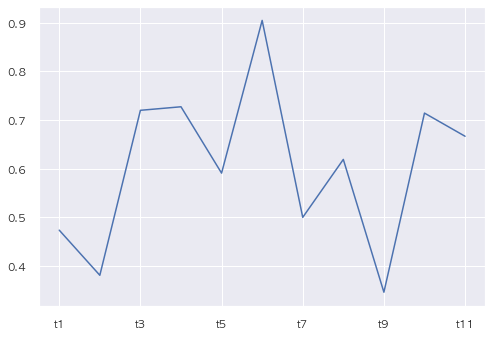

김재환


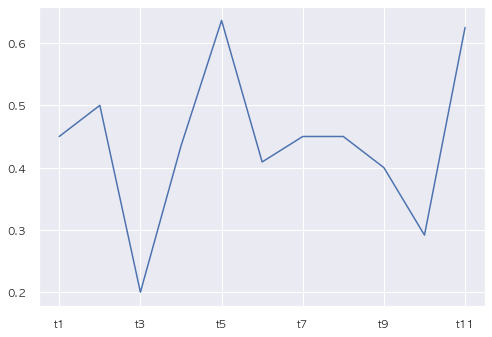

김현수


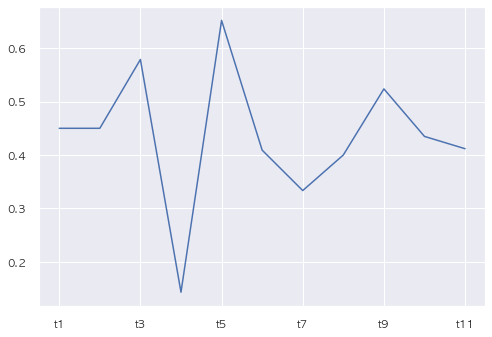

로맥


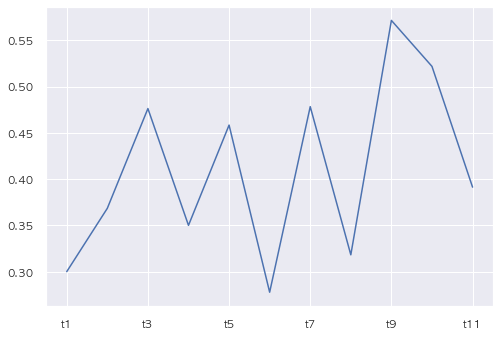

박건우


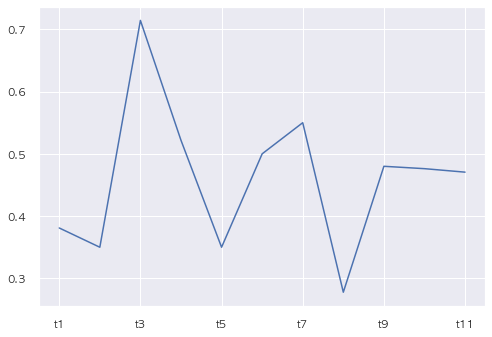

양의지


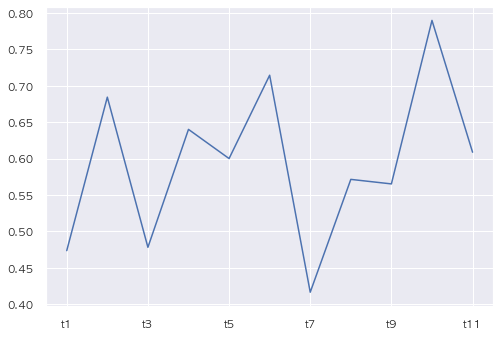

이정후


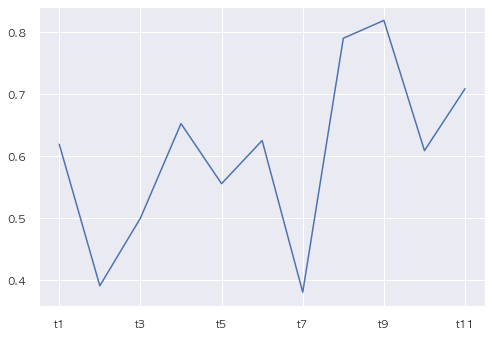

전준우


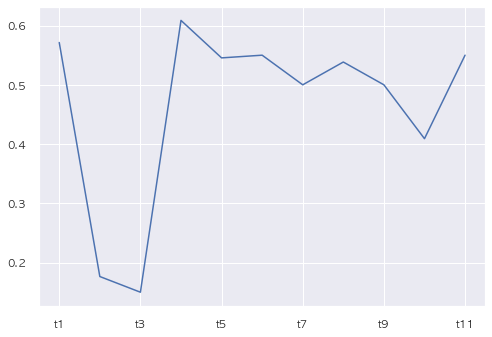

채은성


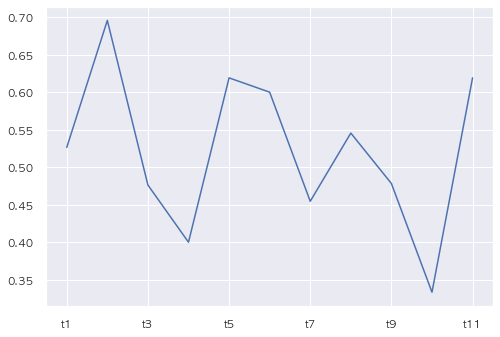

최정


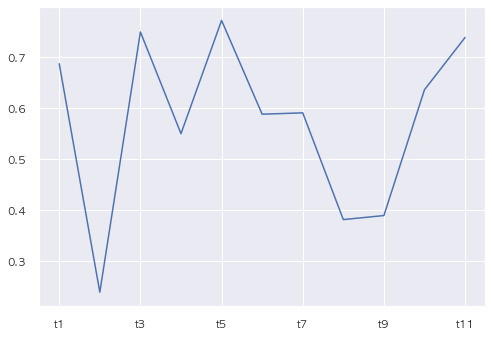

In [228]:
for i in range(len(target)):
    print(tot_seq[tot_seq.index.isin(target)].index[i])
    tot_seq[tot_seq.index.isin(target)].iloc[i,:].plot()
    plt.show()

강백호
김재환
김현수
로맥
박건우
양의지
이정후
전준우
채은성
최정


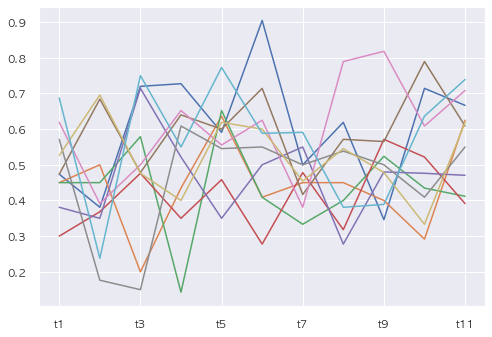

In [231]:
for i in range(len(tot_seq[tot_seq.index.isin(target)])):
    print(tot_seq[tot_seq.index.isin(target)].index[i])
    tot_seq[tot_seq.index.isin(target)].iloc[i,:].plot()


In [ ]:
김현수, 김재환,최정

In [232]:
target

['강백호', '김재환', '김현수', '로맥', '박건우', '양의지', '전준우', '채은성', '최정', '이정후']

In [240]:
x_test = pd.read_csv(os.path.join('../dataset', 'baseball_test_final.csv'))

In [241]:
x_test

,PCODE,NAME,year,선발,타수,득점,안타,2타,3타,홈런,...,희비,투구,barrel,start_date,end_date,gap,게임수,출루,장타,series_index
0,67341.0,이정후,2021,14,54,6,19,4,0,0,...,0,251,3.0,2021-06-26,2021-08-14,-49 days,15,NaN,NaN,t0
1,67872.0,로맥,2021,10,38,5,8,1,0,1,...,0,193,0.0,2021-07-11,2021-09-08,-59 days,15,NaN,NaN,t0
2,68050.0,강백호,2021,14,56,8,16,6,0,3,...,5,260,4.0,2021-08-18,2021-09-08,-21 days,15,NaN,NaN,t0
3,75847.0,최정,2021,14,44,9,10,2,1,4,...,3,214,5.0,2021-08-20,2021-09-08,-19 days,15,NaN,NaN,t0
4,76232.0,양의지,2021,15,52,7,15,5,0,2,...,0,238,7.0,2021-08-20,2021-09-08,-19 days,15,NaN,NaN,t0
5,78224.0,김재환,2021,15,53,6,15,3,0,1,...,1,224,5.0,2021-08-21,2021-09-08,-18 days,15,NaN,NaN,t0
6,78513.0,전준우,2021,14,56,10,15,4,0,1,...,2,218,7.0,2021-08-18,2021-09-08,-21 days,15,NaN,NaN,t0
7,79192.0,채은성,2021,15,54,13,18,3,0,4,...,3,250,9.0,2021-06-19,2021-09-08,-81 days,15,NaN,NaN,t0
8,76290.0,김현수,2021,15,49,4,14,4,1,0,...,1,204,6.0,2021-08-18,2021-09-08,-21 days,15,NaN,NaN,t0
9,79215.0,박건우,2021,15,50,8,14,2,0,0,...,0,223,4.0,2021-08-21,2021-09-08,-18 days,15,NaN,NaN,t0
